In [1]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import torch
from cytoolz import pipe

from pyrlmala.learning import LearningFactory
from pyrlmala.learning.callback import Callback
from pyrlmala.utils import AveragePolicy, Toolbox

In [2]:
plot_agent_500 = partial(Toolbox.plot_agent, steps_per_episode=500)

In [3]:
model_name = "test-laplace_2-test-laplace_2"
posteriordb_path = "../posteriordb/posterior_database"

In [4]:
sample_dim = 2
initial_sample = 0.1 * np.ones(sample_dim)
initial_step_size = np.array([0.1])
algorithm = "ddpg"
mcmc_env = "mala"
runtime_config_path = f"./config/runtime_{mcmc_env}.toml"

learning_instance = LearningFactory.create_learning_instance(
    algorithm=algorithm,
    model_name=model_name,
    posteriordb_path=posteriordb_path,
    initial_sample=initial_sample,
    initial_step_size=initial_step_size,
    hyperparameter_config_path=f"./config/{algorithm}_{mcmc_env}.toml",
    actor_config_path="./config/actor.toml",
    critic_config_path="./config/critic.toml",
)

Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

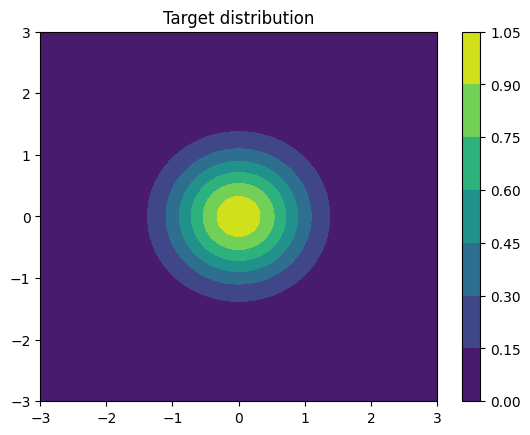

In [5]:
data_range = ((-3, 3, 100), (-3, 3, 100))
Toolbox.target_plot(data_range, learning_instance.env.envs[0].get_wrapper_attr("log_target_pdf"))

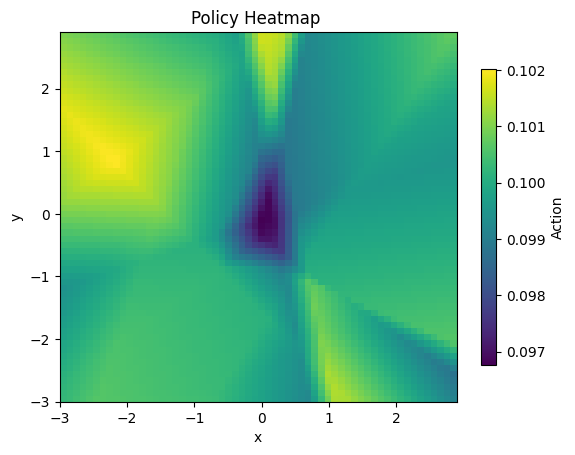

In [6]:
x_range = (-3, 3, 0.1)
y_range = (-3, 3, 0.1)

policy = lambda x: learning_instance.actor(x.double())

Toolbox.policy_plot_2D_heatmap(policy, torch.arange(*x_range), torch.arange(*y_range))

In [7]:
visualizer_and_actor_lr_instance = Callback(
    learning_instance,
    plot_frequency=100,
    num_of_mesh=10,
    auto_start=True,
    runtime_config_path=runtime_config_path,
    actor_folder_path=f"./weights/{mcmc_env}/actor",
    actor_save_after_steps=1,
    actor_save_frequency=10,
)

Callback observer started.


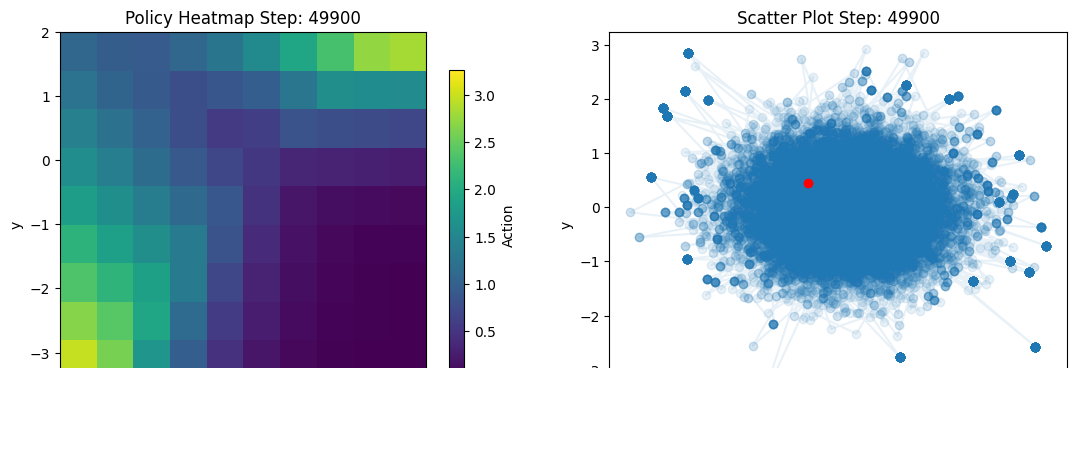

In [8]:
visualizer_and_actor_lr_instance.train()

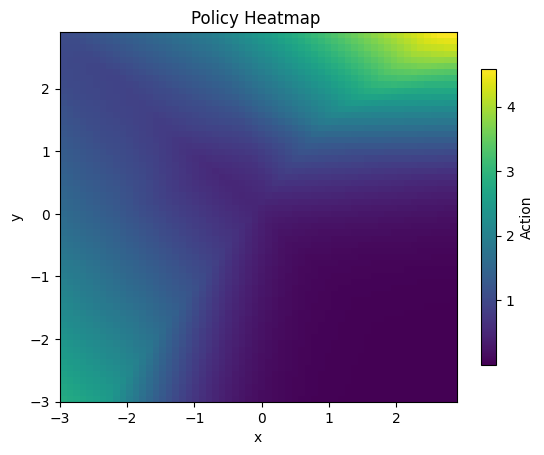

In [9]:
Toolbox.policy_plot_2D_heatmap(policy, torch.arange(*x_range), torch.arange(*y_range))

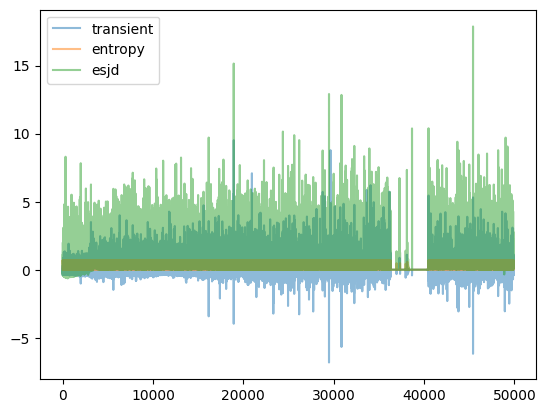

In [10]:
lower_window_size = 0
upper_window_size = learning_instance.env.envs[0].get_wrapper_attr("current_step") - 1

reward_item_plot = lambda tpl: plt.plot(tpl[1][lower_window_size:upper_window_size], label=f"{tpl[0]}", alpha=0.5)

pipe(
    learning_instance.env.envs[0],
    lambda env: (
        ("transient", env.get_wrapper_attr("reward_items")["transient"]),
        ("entropy", env.get_wrapper_attr("reward_items")["entropy"]),
        ("esjd", env.get_wrapper_attr("reward_items")["expected_square_jump_distance"])
    ),
    lambda tpl: (reward_item_plot(tpl[0]), reward_item_plot(tpl[1]), reward_item_plot(tpl[2])),
    lambda _: plt.legend(),
    lambda _: plt.show()
)

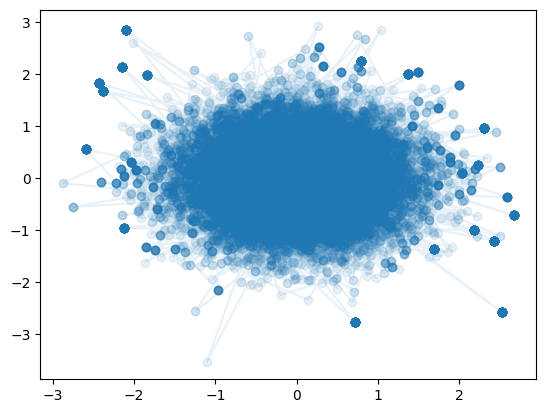

In [11]:
accepted_sample = pipe(
    learning_instance,
    lambda x: getattr(x, "env"),
    lambda x: x.get_attr("store_accepted_sample"),
)[0]

plt.plot(
    accepted_sample[lower_window_size:upper_window_size, 0],
    accepted_sample[lower_window_size:upper_window_size, 1],
    'o-', alpha=0.1)
plt.show()

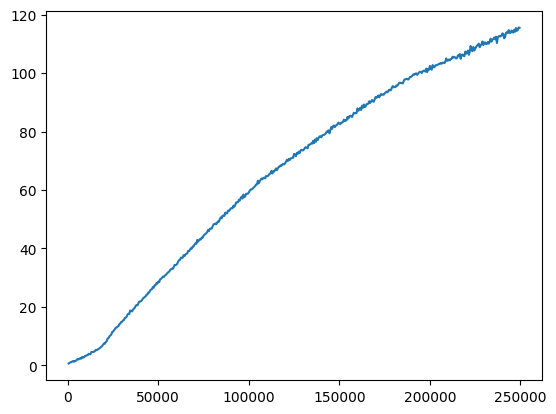

In [12]:
pipe(learning_instance, lambda x: getattr(x, "critic_values"), plot_agent_500)

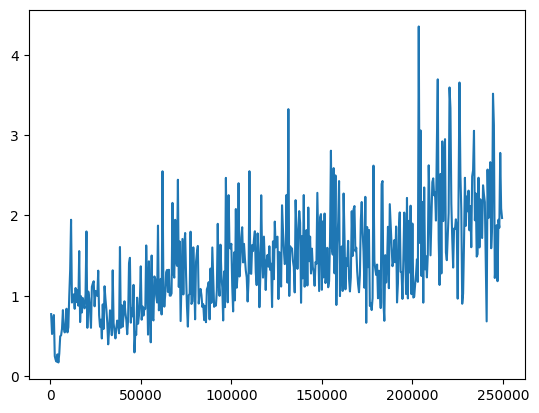

In [13]:
pipe(learning_instance, lambda x: getattr(x, "critic_loss"), plot_agent_500)

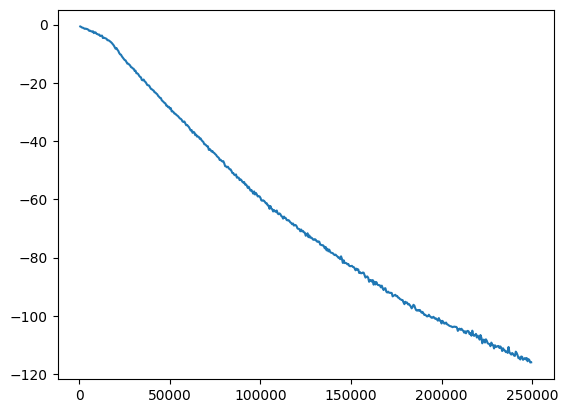

In [14]:
pipe(learning_instance, lambda x: getattr(x, "actor_loss"), plot_agent_500)

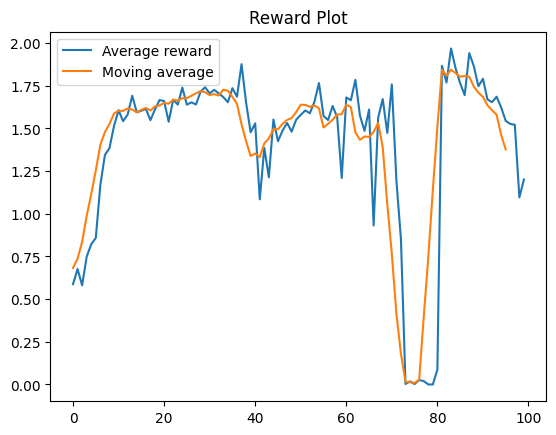

In [15]:
reward = pipe(
    learning_instance,
    lambda x: getattr(x, "env"),
    lambda x: x.get_attr("store_reward")[0],
    Toolbox.reward_plot
)

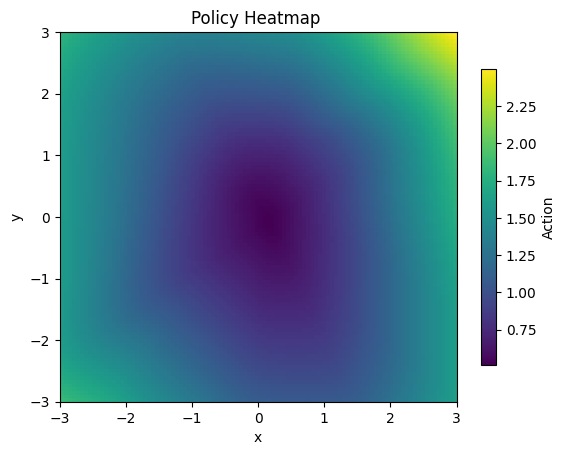

In [16]:
AveragePolicy.plot_policy(
    learning_instance.actor,
    f"./weights/{mcmc_env}/actor/*.pth",
    data_range,
    5000,
    100,
)

In [17]:
Toolbox.create_folder("./data")
np.save(f"./data/laplace_2_const_{mcmc_env}.npy", accepted_sample)

In [18]:
gs = Toolbox.gold_standard(model_name, posteriordb_path)

In [19]:
Toolbox.batched_mmd(
    torch.from_numpy(gs), torch.from_numpy(accepted_sample), batch_size=1_000, sigma=1.0
)

tensor(1.6361, dtype=torch.float64)